In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 20)

#### Частина 1. Аналіз та підготовка даних

* Перевір на наявність пропущених значень. 
* За наявності заповни їх або видали рядки з пропусками.
* За наявності бінарних ознак заміни значення цих ознак на 0 та 1.
* Проаналізуй діапазони значень, їх середні та дисперсію, розподіли, кореляції, типи ознак.

In [2]:
df = pd.read_csv('data/rent/House_Rent_Dataset.csv')
df

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2,15000,1000,3 out of 5,Carpet Area,Bandam Kommu,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner
4742,2022-05-15,3,29000,2000,1 out of 4,Super Area,"Manikonda, Hyderabad",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4743,2022-07-10,3,35000,1750,3 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent
4744,2022-07-06,3,45000,1500,23 out of 34,Carpet Area,Gachibowli,Hyderabad,Semi-Furnished,Family,2,Contact Agent


In [3]:
# Перевірка наявності пропущених значень
df.isnull().sum()

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64

Пропущених даних не виявлено, переходимо до наступного кроку. Проаналізувавши дані ми виявили, що бінарних колонок (ознак) нема. Тому переходимо до статистичного аналізу. Але перед цим для зручності роботи ми перейменуємо колонки.

In [4]:
df = df.rename(columns={
    'Posted On': 'post_date',
    'BHK': 'bhk',
    'Rent': 'rent',
    'Size': 'size',
    'Floor': 'floor',
    'Area Type': 'area_type',
    'Area Locality': 'locality',
    'City': 'city',
    'Furnishing Status': 'furnish',
    'Tenant Preferred': 'tenant',
    'Bathroom': 'bath',
    'Point of Contact': 'contact'
})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post_date  4746 non-null   object
 1   bhk        4746 non-null   int64 
 2   rent       4746 non-null   int64 
 3   size       4746 non-null   int64 
 4   floor      4746 non-null   object
 5   area_type  4746 non-null   object
 6   locality   4746 non-null   object
 7   city       4746 non-null   object
 8   furnish    4746 non-null   object
 9   tenant     4746 non-null   object
 10  bath       4746 non-null   int64 
 11  contact    4746 non-null   object
dtypes: int64(4), object(8)
memory usage: 445.1+ KB


Поглянемо на загальну статистику даних.

In [6]:
df.describe()

,bhk,rent,size,bath
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


Поглянемо скільки унікальних даних мають категоріальні фічі.

In [7]:
for col in df.select_dtypes(include=['object']).columns:
    print(f'{col} ({len(df[col].unique())}):')

post_date (81):
floor (480):
area_type (3):
locality (2235):
city (6):
furnish (3):
tenant (3):
contact (3):


На основі цих даних я вирішив зробити наступне:

1. Обробка дати (post_date): Перетворити post_date на формат datetime та виділити місяць.
2. Обробка floor: Розділити на current_floor та total_floors.
3. Категоріальні ознаки (area_type, furnish, tenant, contact, city): Виконати one-hot encoding.
4. Аналіз locality: Видалити через надмірно велику варіативність.

In [8]:
# Перетворення `post_date` на datetime та виділення місяця
df['post_date'] = pd.to_datetime(df['post_date'])
df['month'] = df['post_date'].dt.month

# Обробка значення `floor`
# Заміна категорій на числові еквіваленти
for old, new in {'Ground': '0', 'Upper': '-1', 'Lower': '-2'}.items():
    df['floor'] = df['floor'].str.replace(old, new)

# Витягування поточного поверху та загальної кількості поверхів
df['max_floor'] = df['floor'].apply(lambda x: int(x.split(' ')[-1]))
df['floor'] = df['floor'].apply(lambda x: int(x.split(' ')[0]))

# Обробка `furnish`: заміна категорій на числові значення
df['furnish'] = df['furnish'].map({'Furnished': 1, 'Unfurnished': 0, 'Semi-Furnished': 0.5})

# Видалення колонки `post_date` після виділення місяця
df = df.drop(['post_date'], axis=1)

# Видалення колонки `locality` через низький вплив
df = df.drop(['locality'], axis=1)

# One-Hot Encoding для `area_type` та `tenant`
df = pd.get_dummies(df, columns=['area_type', 'tenant', 'city', 'contact'], drop_first=True)

# Видалення оригінальних категоріальних ознак після One-Hot Encoding (якщо вказані в списку)
columns_to_drop_after_encoding = ['area_type', 'tenant', 'city', 'contact']
df = df.drop(columns=columns_to_drop_after_encoding, axis=1, errors='ignore')

# Перегляд перших рядків після обробки
df

,bhk,rent,size,floor,furnish,bath,month,max_floor,area_type_Carpet Area,area_type_Super Area,tenant_Bachelors/Family,tenant_Family,city_Chennai,city_Delhi,city_Hyderabad,city_Kolkata,city_Mumbai,contact_Contact Builder,contact_Contact Owner
0,2,10000,1100,0,0.0,2,5,2,False,True,True,False,False,False,False,True,False,False,True
1,2,20000,800,1,0.5,1,5,3,False,True,True,False,False,False,False,True,False,False,True
2,2,17000,1000,1,0.5,1,5,3,False,True,True,False,False,False,False,True,False,False,True
3,2,10000,800,1,0.0,1,7,2,False,True,True,False,False,False,False,True,False,False,True
4,2,7500,850,1,0.0,1,5,2,True,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2,15000,1000,3,0.5,2,5,5,True,False,True,False,False,False,True,False,False,False,True
4742,3,29000,2000,1,0.5,3,5,4,False,True,True,False,False,False,True,False,False,False,True
4743,3,35000,1750,3,0.5,3,7,5,True,False,True,False,False,False,True,False,False,False,False
4744,3,45000,1500,23,0.5,2,7,34,True,False,False,True,False,False,True,False,False,False,False


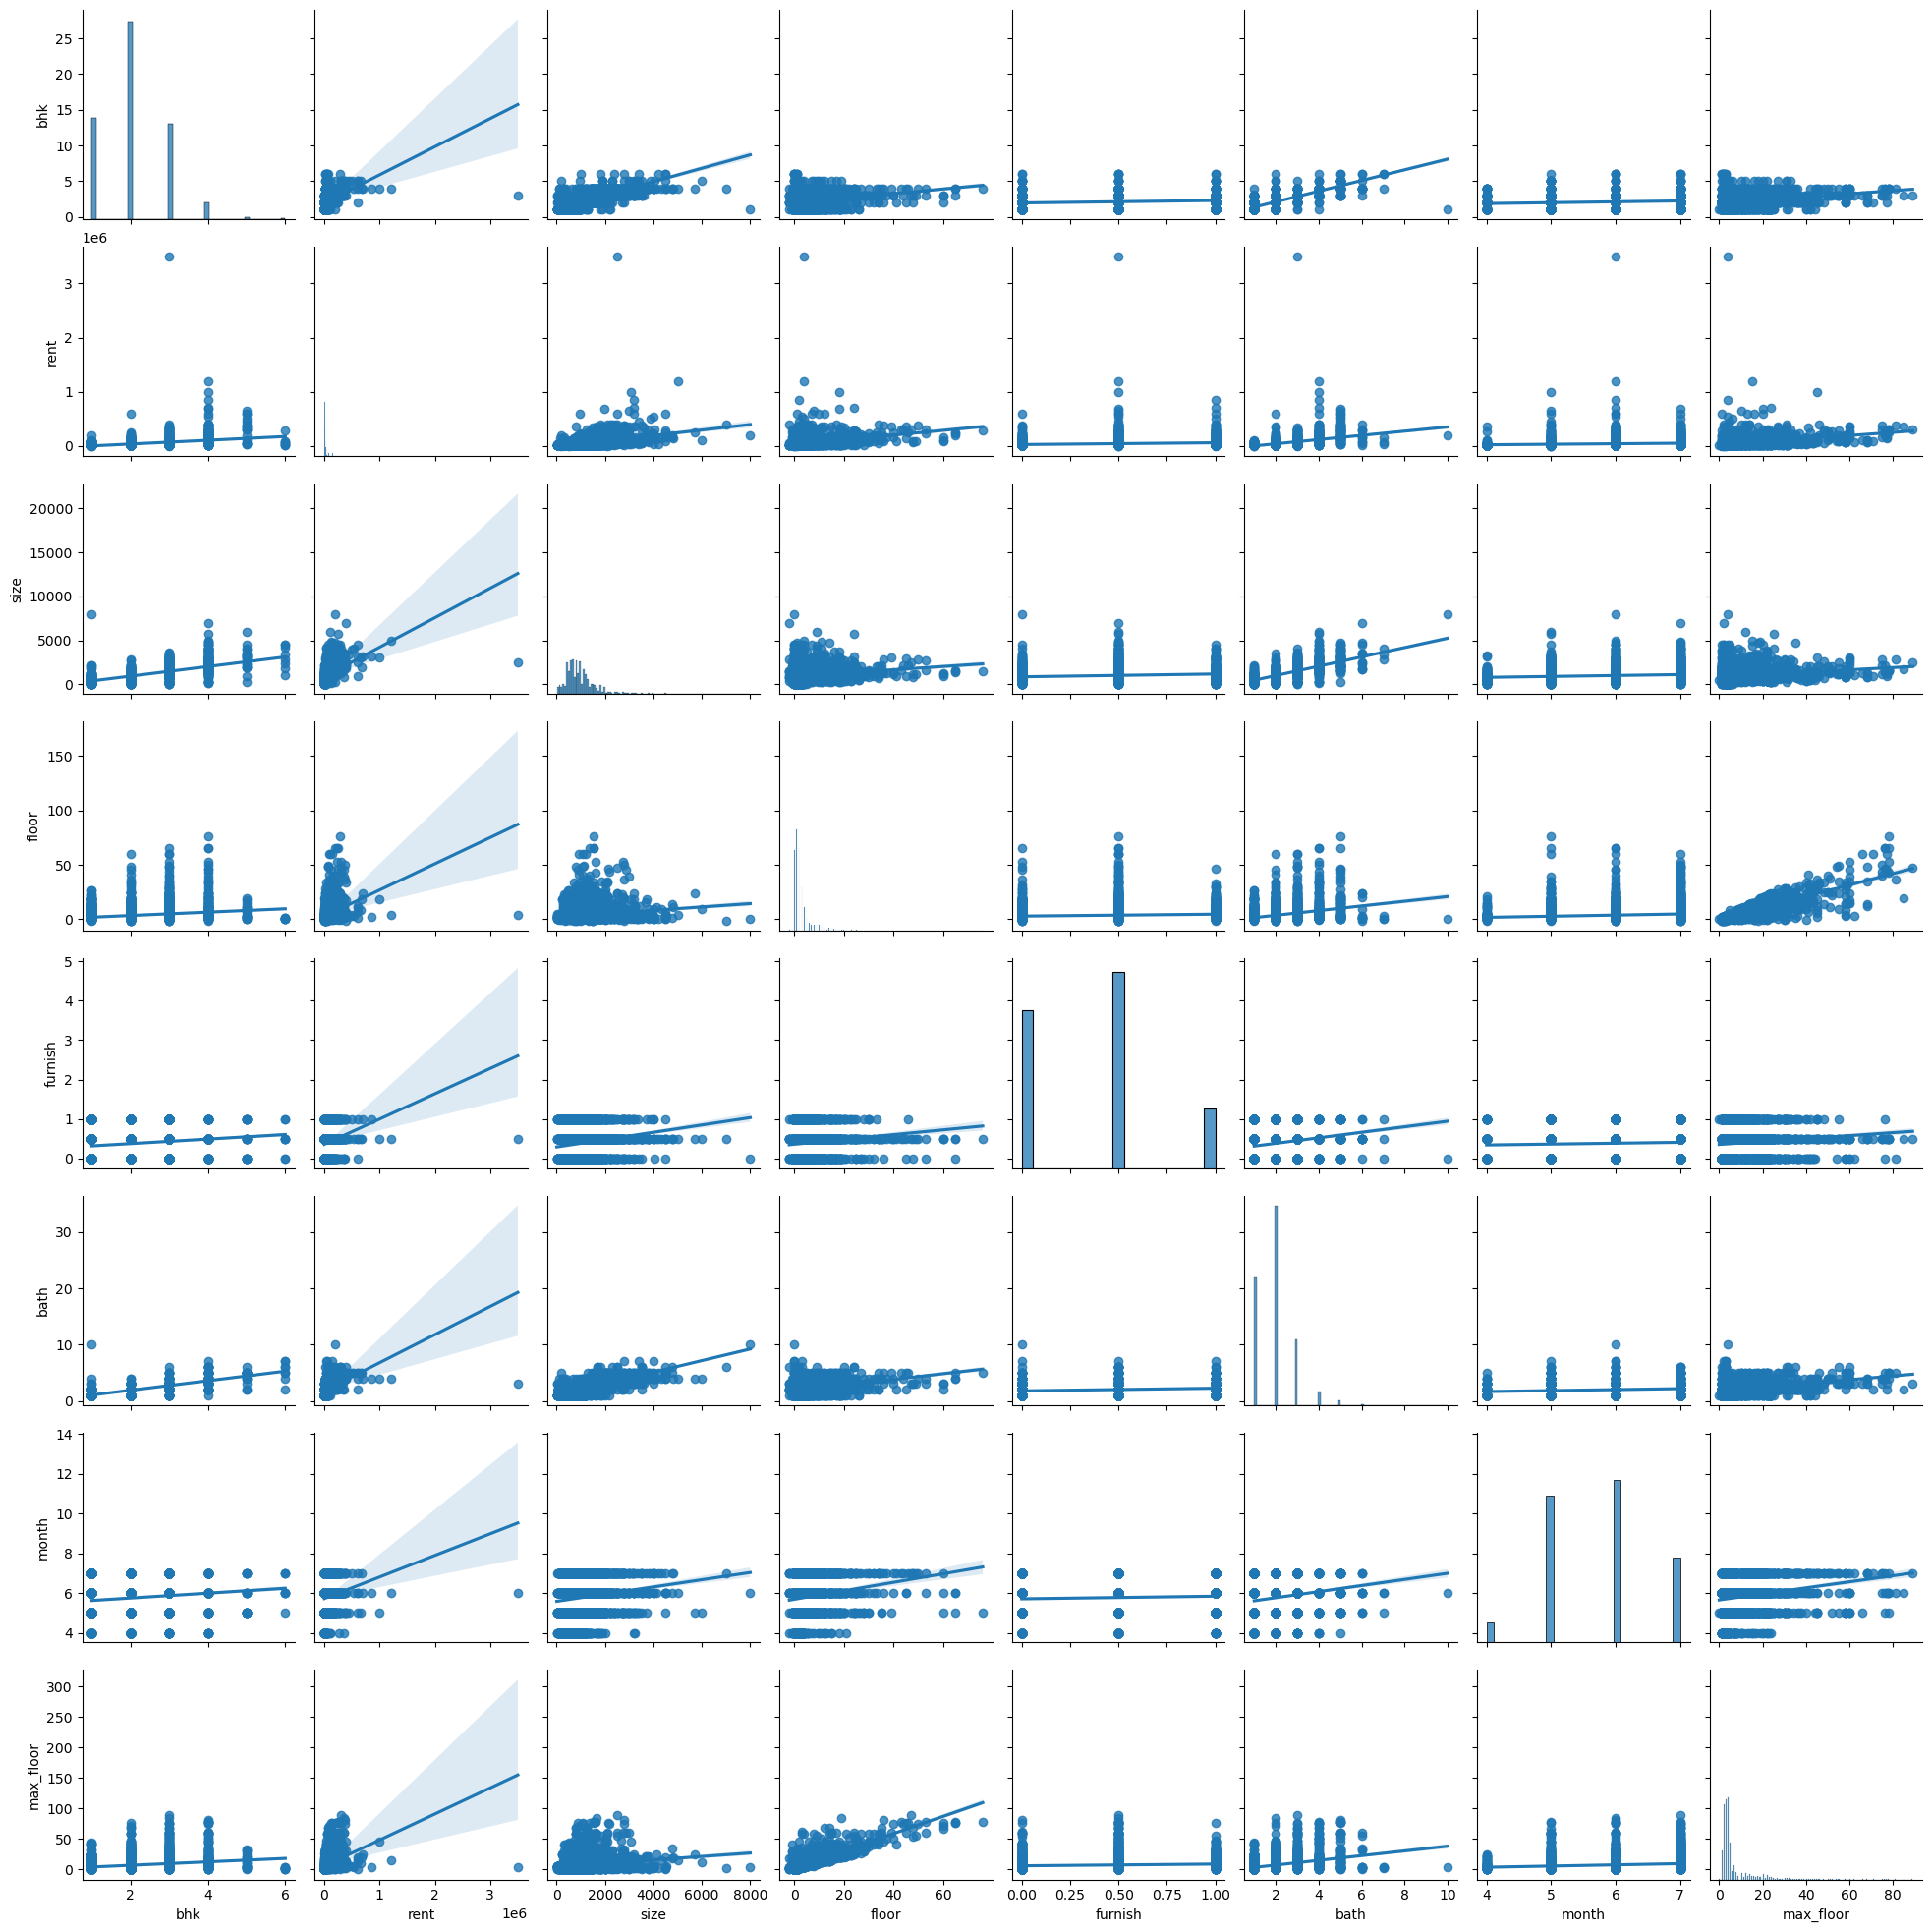

In [9]:
sns.pairplot(df[['bhk', 'rent', 'size', 'floor', 'furnish', 'bath', 'month', 'max_floor']], kind='reg')

На основі аналізу графіків ми побачили що є дані які випадають із загальних трендів і збивають таким чином статистику. Видалимо їх.

In [10]:
df.rent.sort_values().tail(10)

1384     600000
726      600000
3656     600000
1319     650000
1484     680000
1459     700000
1329     850000
827     1000000
1001    1200000
1837    3500000
Name: rent, dtype: int64

In [15]:
df = df.drop(index=[1837])

KeyError: '[1837] not found in axis'

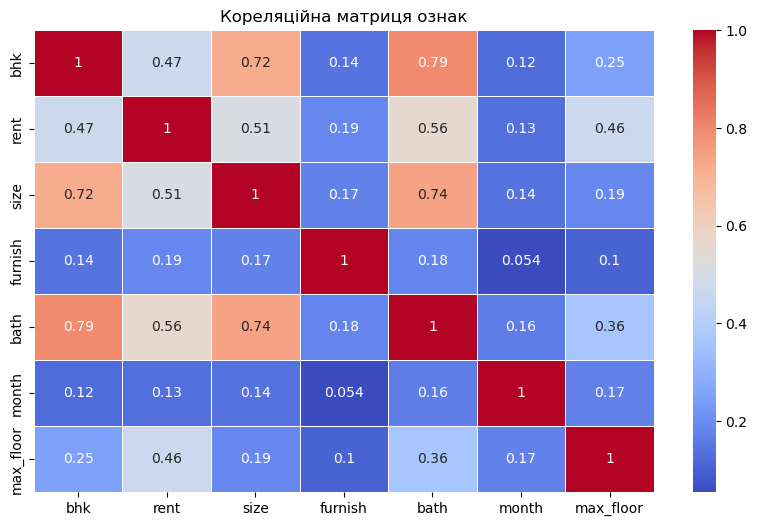

In [18]:
# Побудова теплової карти
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Кореляційна матриця ознак")
plt.show()

# Кореляційна матриця
# correlation_matrix = df[['bhk', 'rent', 'size', 'furnish', 'bath', 'month', 'max_floor']].corr()
# Відображення кореляційної матриці у вигляді таблиці
# print(correlation_matrix)

Загальний висновок:
* Основні фактори, які впливають на орендну плату (rent), це кількість спалень (bhk), розмір (size), та кількість ванних кімнат (bath).
* Менш важливими є такі фактори, як меблювання (furnish) та місяць публікації (month).
* max_floor має помірний вплив, що може вказувати на те, що орендна плата трохи залежить від загальної висоти будівлі.

#### Частина 2. Моделювання

Створи як мінімум 2 різні регресійні моделі для прогнозування цільової змінної “Rent”. 

In [19]:
# Імпорт необхідних бібліотек
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [20]:
# Розділення на тренувальну та тестову вибірки
target = 'rent'
X = df.drop(columns=[target])
y = df[target]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Функція для оцінки кожної моделі
def evaluate_model(model, x_train, x_test, y_train, y_test, results):
    # Навчання моделі
    model.fit(x_train, y_train)
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)

    # Оцінка моделі
    train_mse = mean_squared_error(y_train, pred_train)
    train_mape = mean_absolute_percentage_error(y_train, pred_train)
    train_r2 = r2_score(y_train, pred_train)

    test_mse = mean_squared_error(y_test, pred_test)
    test_mape = mean_absolute_percentage_error(y_test, pred_test)
    test_r2 = r2_score(y_test, pred_test)

    # Збереження результатів для подальшого аналізу
    results.append({
        'Model': model.__class__.__name__,
        'Parameters': model.get_params(),
        'Train R2': round(train_r2, 2),
        'Test R2': round(test_r2, 2),
        'Train MSE': round(train_mse, 2),
        'Test MSE': round(test_mse, 2),
        'Train MAPE': round(train_mape, 2),
        'Test MAPE': round(test_mape, 2)
    })

    # Вивід метрик для поточної моделі
    print(f"{model.__class__.__name__}:")
    print(f"Train - MSE: {train_mse:.2f}, MAPE: {train_mape:.2f}, R2: {train_r2:.2f}")
    print(f"Test  - MSE: {test_mse:.2f}, MAPE: {test_mape:.2f}, R2: {test_r2:.2f}\n")

    # Графічна оцінка якості моделі
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Діаграма реальних та передбачених значень
    sns.scatterplot(x=y_test, y=pred_test, ax=axes[0], alpha=0.6)
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], color='red', ax=axes[0])
    axes[0].set_xlabel("Actual Rent")
    axes[0].set_ylabel("Predicted Rent")
    axes[0].set_title("Actual vs Predicted Rent")

    # Помилки передбачення
    sns.scatterplot(x=y_test, y=pred_test - y_test, ax=axes[1], alpha=0.6)
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[0, 0], color='red', ax=axes[1])
    axes[1].set_xlabel("Actual Rent")
    axes[1].set_ylabel("Residual (Prediction - Actual)")
    axes[1].set_title("Residual Analysis")

    # Порівняння розподілу реальних та передбачених значень
    sns.histplot(y_test, color='blue', alpha=0.6, label='Actual Rent', bins=20, ax=axes[2])
    sns.histplot(pred_test, color='red', alpha=0.6, label='Predicted Rent', bins=20, ax=axes[2])
    axes[2].legend()
    axes[2].set_title("Distribution: Actual vs Predicted Rent")

    plt.tight_layout()
    plt.show()

LinearRegression:
Train - MSE: 1625905744.05, MAPE: 1.08, R2: 0.52
Test  - MSE: 2033702772.11, MAPE: 1.08, R2: 0.51



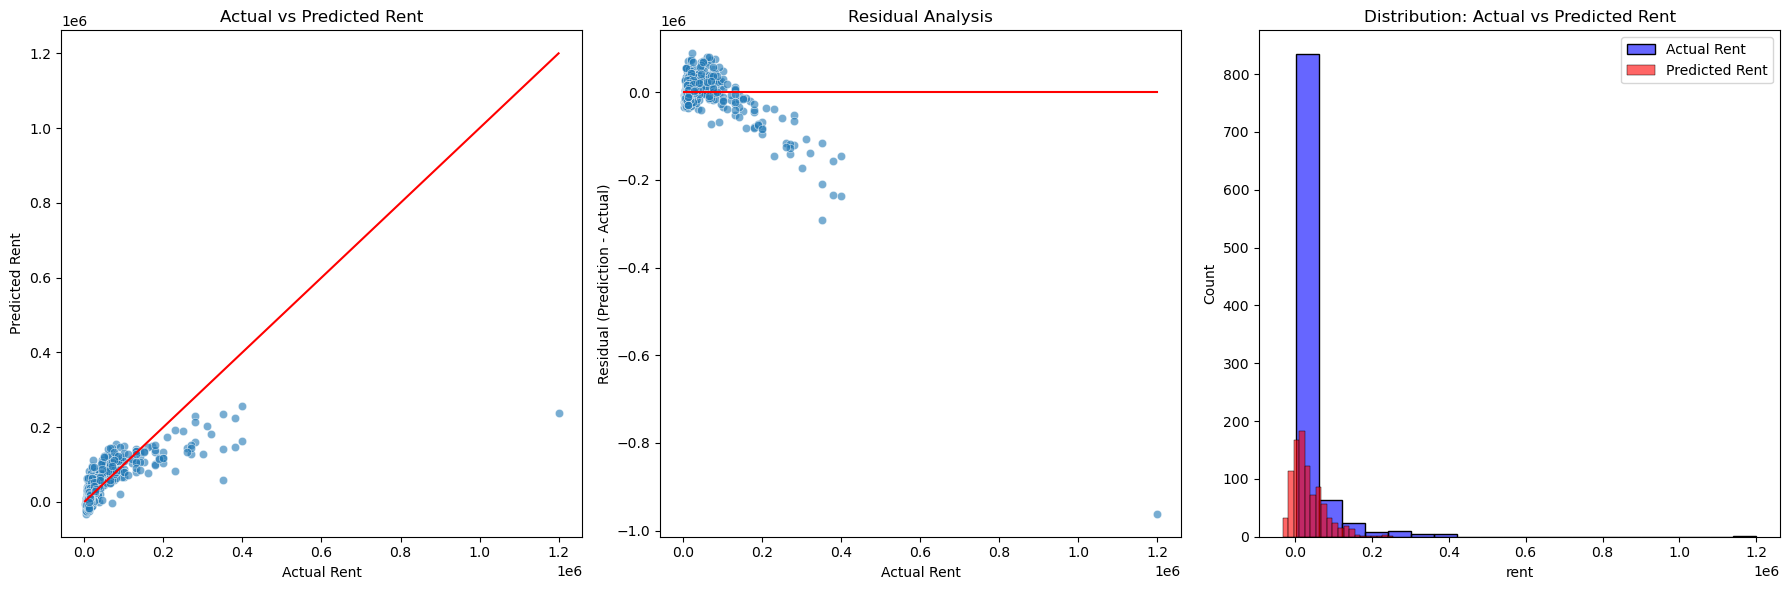

DecisionTreeRegressor:
Train - MSE: 331332.32, MAPE: 0.01, R2: 1.00
Test  - MSE: 2872388040.76, MAPE: 0.59, R2: 0.31



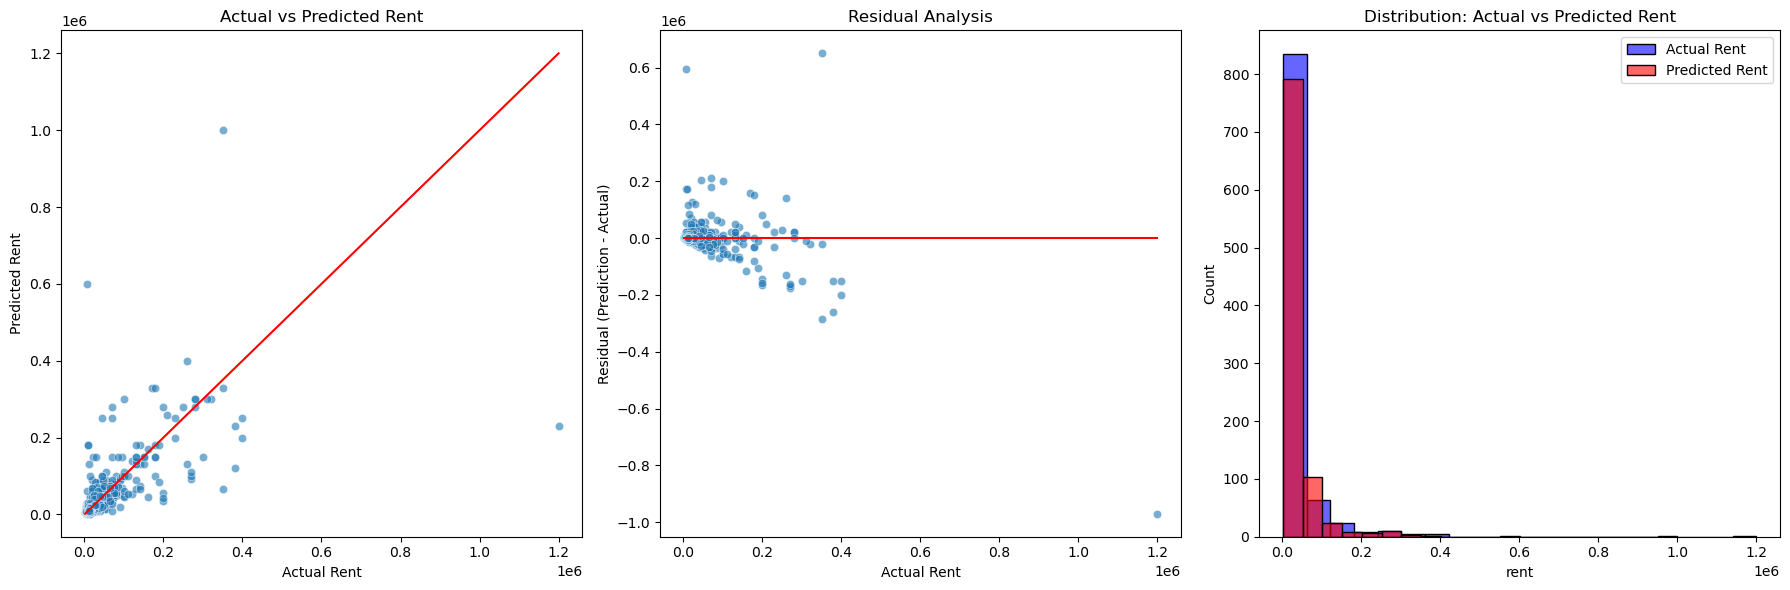

DecisionTreeRegressor:
Train - MSE: 1045096693.82, MAPE: 0.59, R2: 0.69
Test  - MSE: 1500166251.62, MAPE: 0.65, R2: 0.64



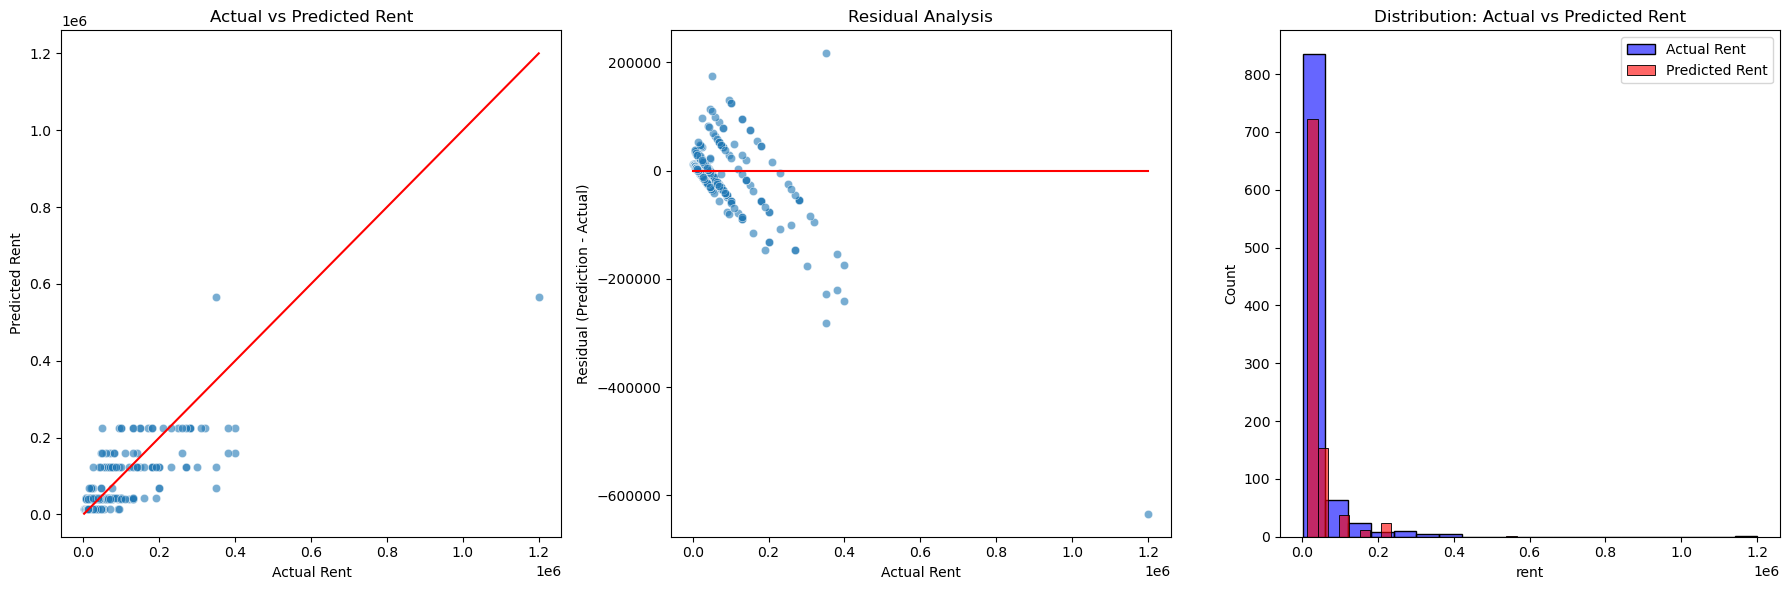

RandomForestRegressor:
Train - MSE: 135798490.15, MAPE: 0.15, R2: 0.96
Test  - MSE: 1268363654.20, MAPE: 0.40, R2: 0.70



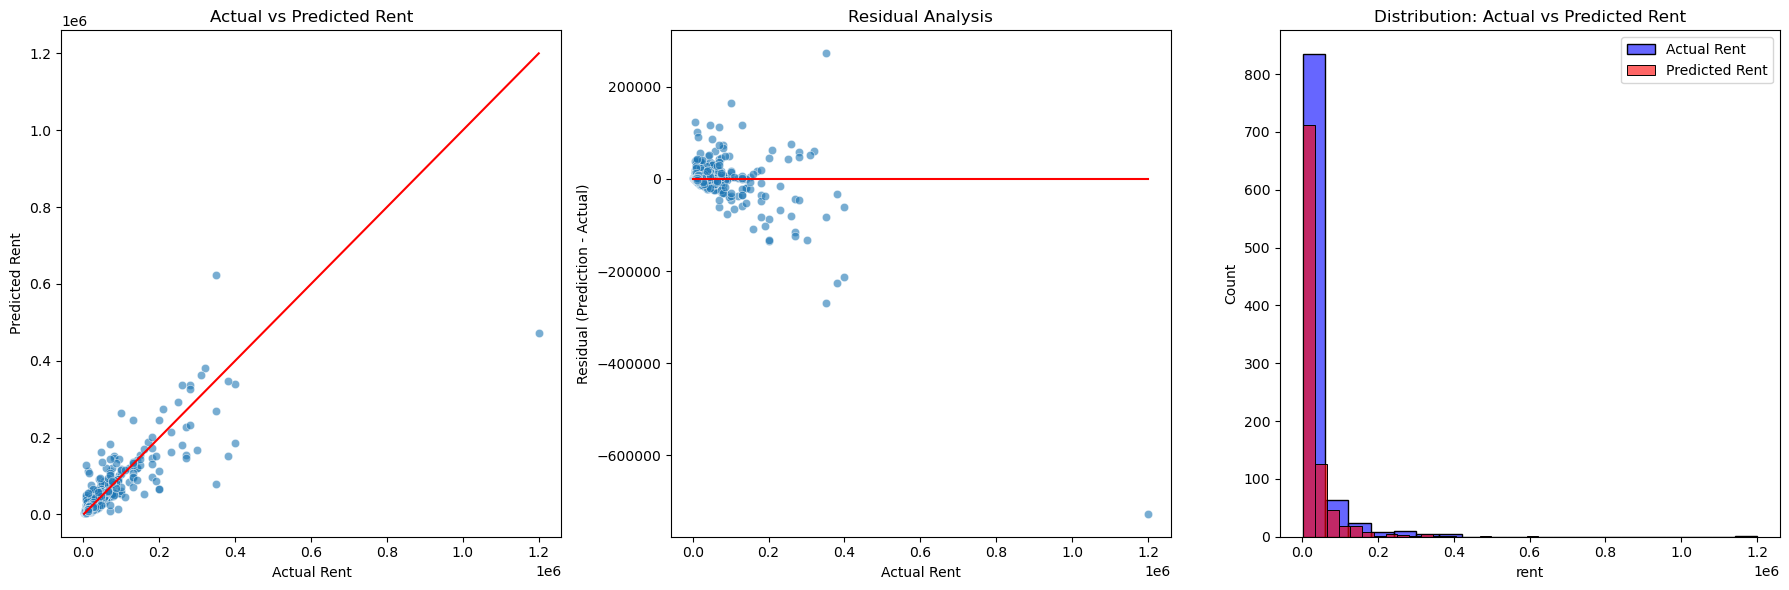

RandomForestRegressor:
Train - MSE: 944130099.78, MAPE: 0.58, R2: 0.72
Test  - MSE: 1357690595.98, MAPE: 0.62, R2: 0.67



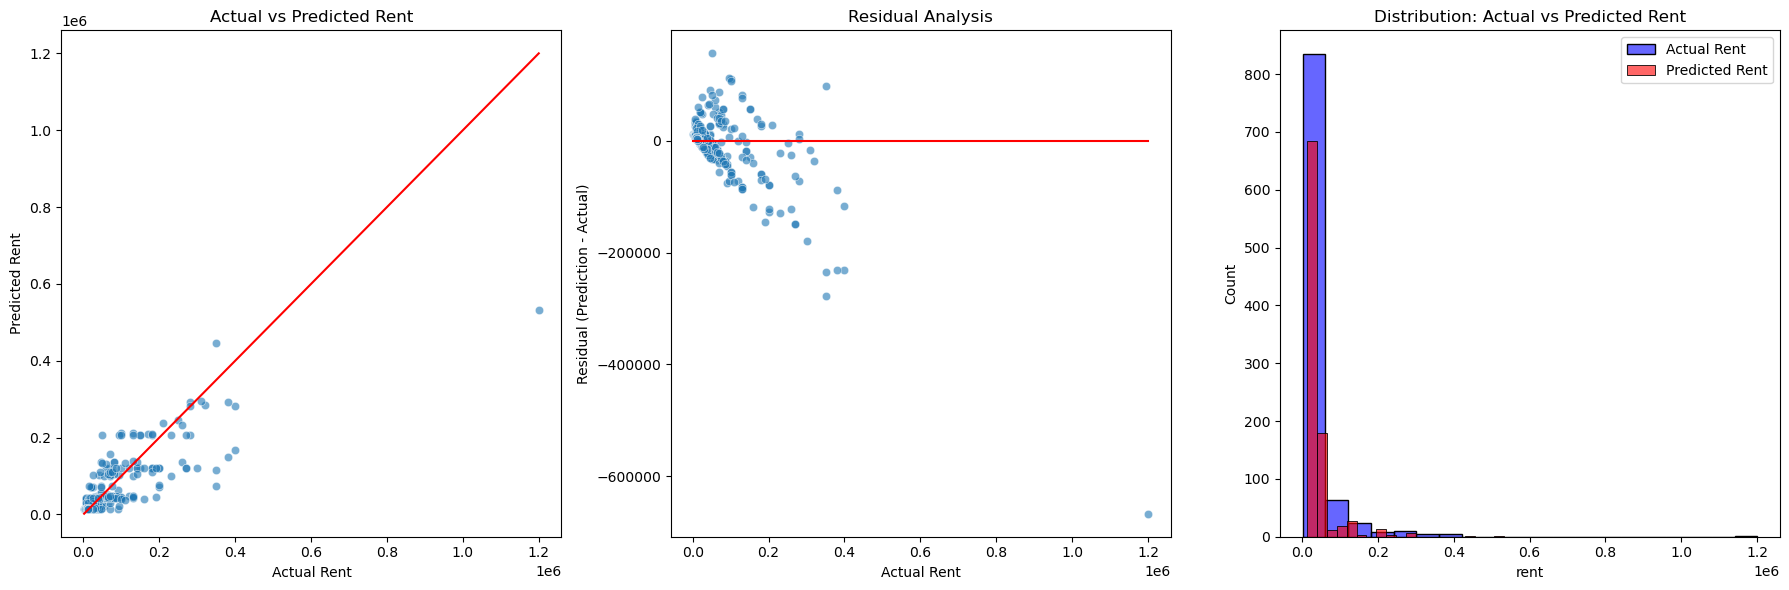

RandomForestRegressor:
Train - MSE: 242412317.63, MAPE: 0.17, R2: 0.93
Test  - MSE: 1378062161.11, MAPE: 0.40, R2: 0.67



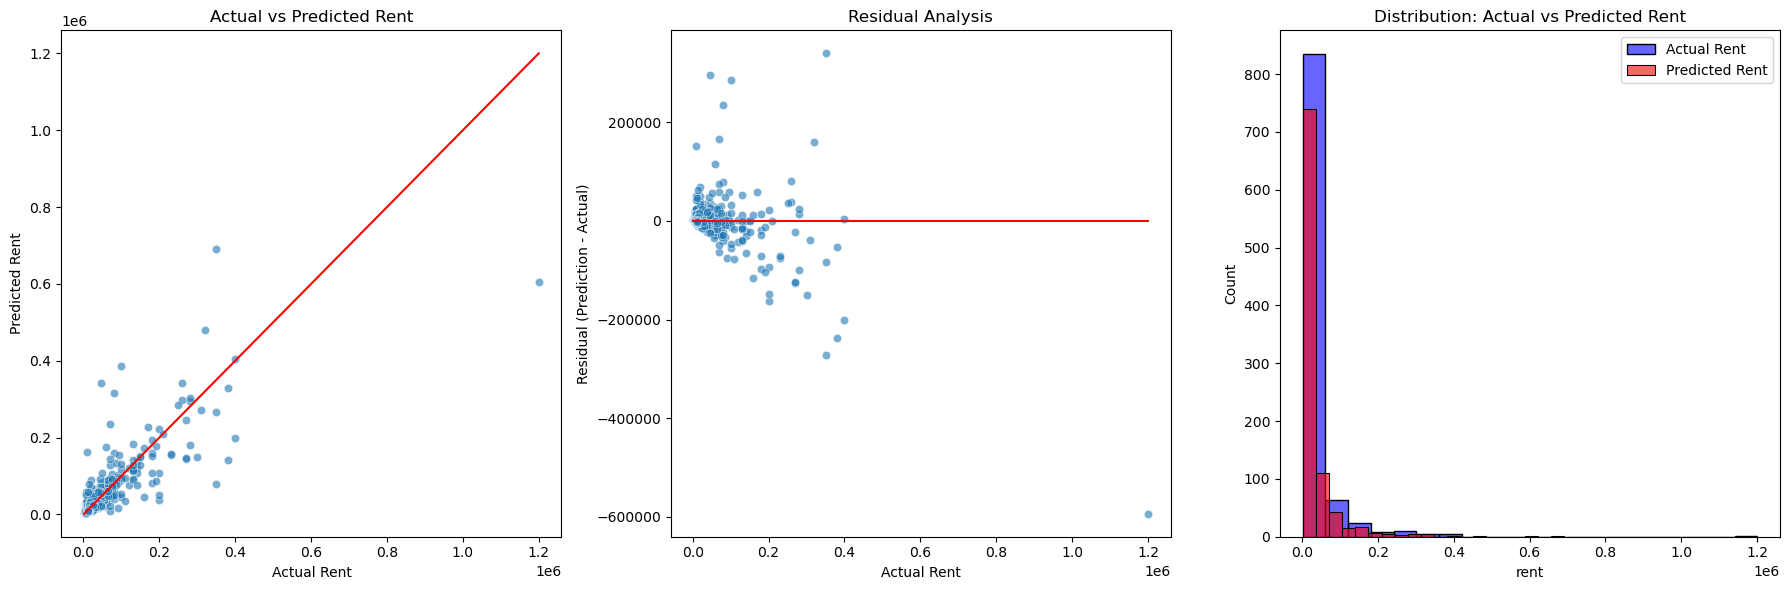

GradientBoostingRegressor:
Train - MSE: 497140992.30, MAPE: 0.36, R2: 0.85
Test  - MSE: 1329553285.67, MAPE: 0.40, R2: 0.68



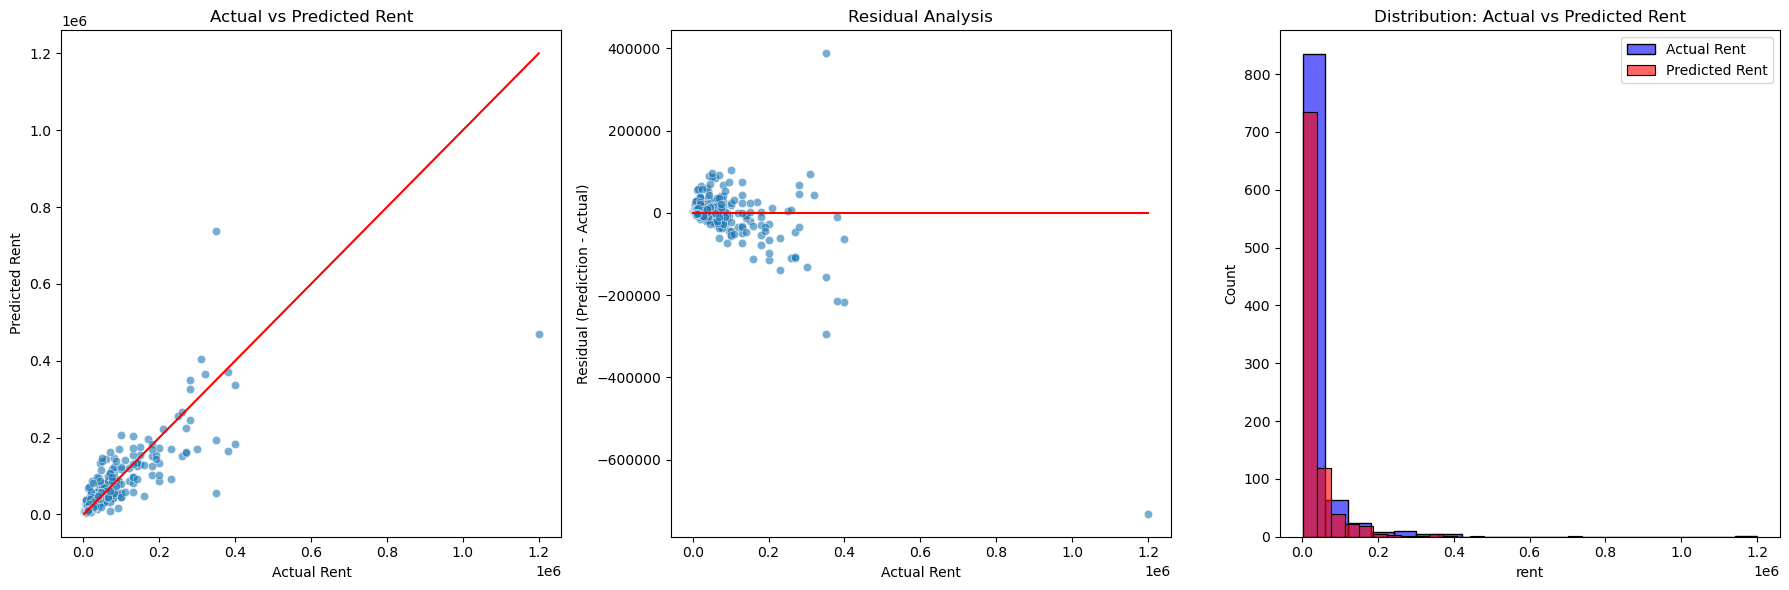

GradientBoostingRegressor:
Train - MSE: 42668934.72, MAPE: 0.21, R2: 0.99
Test  - MSE: 1406756137.49, MAPE: 0.40, R2: 0.66



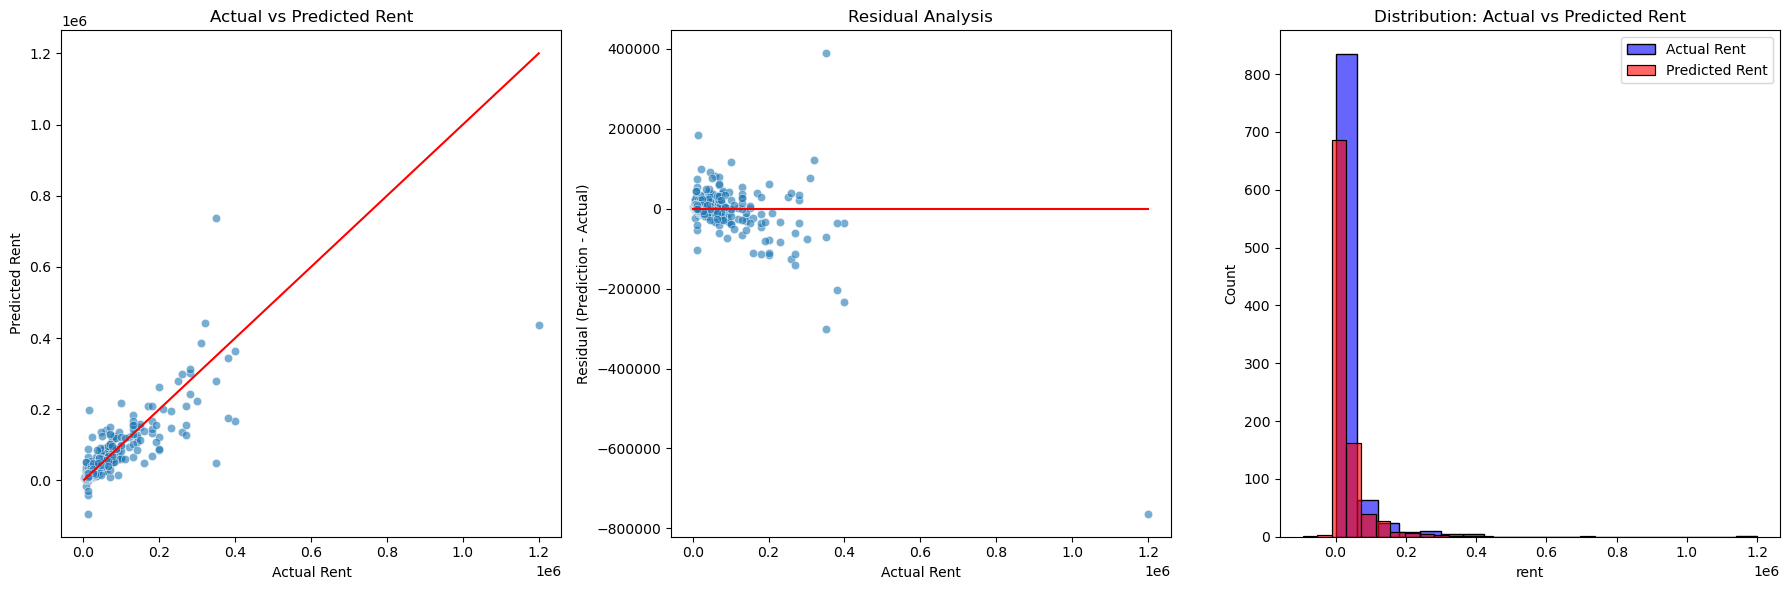

GradientBoostingRegressor:
Train - MSE: 1192430396.65, MAPE: 1.00, R2: 0.65
Test  - MSE: 2671702749.30, MAPE: 1.12, R2: 0.36



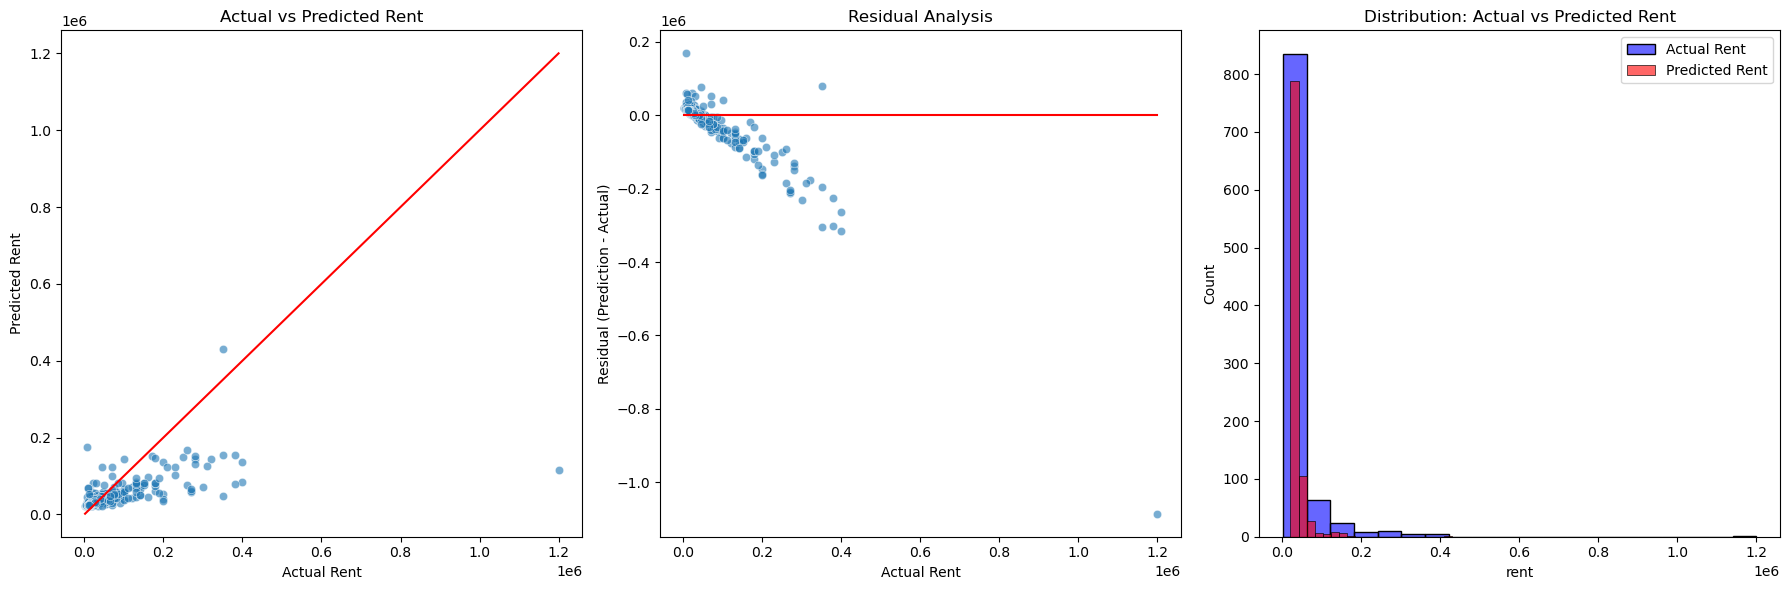

In [27]:
# Підготовка результатів для кожної моделі
results = []

# Створення моделей
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    DecisionTreeRegressor(max_depth=3),
    RandomForestRegressor(),
    RandomForestRegressor(max_depth=3, n_estimators=500),
    RandomForestRegressor(max_depth=100, n_estimators=5),
    GradientBoostingRegressor(),
    GradientBoostingRegressor(max_depth=5, n_estimators=500),
    GradientBoostingRegressor(max_depth=500, n_estimators=5)
]

# Оцінка та збереження результатів для кожної моделі
for model in models:
    evaluate_model(model, x_train, x_test, y_train, y_test, results)

In [28]:
# Підсумковий текстовий звіт
print("\nПідсумкова продуктивність моделей:\n")
for res in results:
    print(f"Модель: {res['Model']}")
    print(f"Параметри: {res['Parameters']}")
    print(f"Train R2: {res['Train R2']}, Test R2: {res['Test R2']}")
    print(f"Train MSE: {res['Train MSE']}, Test MSE: {res['Test MSE']}")
    print(f"Train MAPE: {res['Train MAPE']}, Test MAPE: {res['Test MAPE']}\n")


Підсумкова продуктивність моделей:

Модель: LinearRegression
Параметри: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
Train R2: 0.52, Test R2: 0.51
Train MSE: 1625905744.05, Test MSE: 2033702772.11
Train MAPE: 1.08, Test MAPE: 1.08

Модель: DecisionTreeRegressor
Параметри: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}
Train R2: 1.0, Test R2: 0.31
Train MSE: 331332.32, Test MSE: 2872388040.76
Train MAPE: 0.01, Test MAPE: 0.59

Модель: DecisionTreeRegressor
Параметри: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_stat

На основі проведеного аналізу можна зробити такі висновки:

1. Лінійна регресія показала середню якість з R2 на тестовій вибірці 0.51, що вказує на обмежену здатність передбачати орендну плату.
2. Decision Tree зі стандартними параметрами сильно перенавчилася (Train R2 = 1.0, Test R2 = 0.31), тоді як модель з обмеженою глибиною (max_depth=3) значно покращила загальні результати (Test R2 = 0.64).
3. Random Forest демонструє найкращі результати серед моделей, зокрема при параметрах (max_depth=3, n_estimators=500) — Test R2 = 0.67.
4. Gradient Boosting також показав хороші результати, особливо при глибині дерев до 3 (Test R2 = 0.68). Проте надто великі глибини (max_depth=500) значно погіршують якість передбачення.

Загалом, найбільш стабільною та якісною виявилась модель Random Forest із параметрами max_depth=3 та n_estimators=500.

Спробуємо знайти кращі параметри за допомогою `GridSearch`

In [30]:
from sklearn.model_selection import GridSearchCV

# Пошук параметрів для лінійної регресії (можна спробувати Lasso або Ridge)
linear_params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Пошук параметрів для Decision Tree
tree_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'friedman_mse']
}

# Пошук параметрів для Random Forest
forest_params = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Пошук параметрів для Gradient Boosting
gb_params = {
    'n_estimators': [50, 100, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0]
}

# Створення моделей
models_and_params = {
    'LinearRegression': (LinearRegression(), linear_params),
    'DecisionTreeRegressor': (DecisionTreeRegressor(), tree_params),
    'RandomForestRegressor': (RandomForestRegressor(), forest_params),
    'GradientBoostingRegressor': (GradientBoostingRegressor(), gb_params)
}

# Оптимізація параметрів для кожної моделі
# Оптимізація параметрів для кожної моделі
for model_name, (model, params) in models_and_params.items():
    print(f"Оптимізація параметрів для {model_name}...")
    try:
        grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='r2', n_jobs=-1, error_score='raise')
        grid_search.fit(x_train, y_train)
        print(f"Найкращі параметри для {model_name}: {grid_search.best_params_}")
        print(f"R2 для тренувальної вибірки: {grid_search.best_score_:.2f}")
        print(f"R2 для тестової вибірки: {r2_score(y_test, grid_search.best_estimator_.predict(x_test)):.2f}\n")
    except Exception as e:
        print(f"Помилка для {model_name} з параметрами: {params}")
        print(str(e))

Оптимізація параметрів для LinearRegression...
Помилка для LinearRegression з параметрами: {'fit_intercept': [True, False], 'positive': [True, False]}
Matrix is singular.
Оптимізація параметрів для DecisionTreeRegressor...
Найкращі параметри для DecisionTreeRegressor: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
R2 для тренувальної вибірки: 0.70
R2 для тестової вибірки: 0.66

Оптимізація параметрів для RandomForestRegressor...
Найкращі параметри для RandomForestRegressor: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
R2 для тренувальної вибірки: 0.74
R2 для тестової вибірки: 0.75

Оптимізація параметрів для GradientBoostingRegressor...
Найкращі параметри для GradientBoostingRegressor: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
R2 для тренувальної вибірки: 0.72
R2 для тестової вибірки: 0.69



Після застосування GridSearch для пошуку оптимальних параметрів ми досягли значного покращення якості для кількох моделей.

1. **Linear Regression** не вдалося оптимізувати через проблему з сингулярною матрицею. Це свідчить про наявність мультиколінеарності в даних або проблему з масштабуванням ознак, що робить модель малоефективною для цього завдання.

2. **Decision Tree Regressor** після оптимізації показав покращення, з `R2` на тестовій вибірці 0.66. Найкращими параметрами стали `max_depth=5`, `min_samples_leaf=4`, та `min_samples_split=2`. Це вказує на те, що контроль глибини дерева та мінімальної кількості зразків на листку суттєво впливають на стабільність моделі.

3. **Random Forest Regressor** продемонстрував найкращу продуктивність серед усіх моделей. З параметрами `max_depth=10`, `min_samples_leaf=4`, `min_samples_split=10`, та `n_estimators=300`, модель досягла `R2 = 0.75` на тестовій вибірці. Це вказує на сильний потенціал використання ансамблевих методів для цього завдання.

4. **Gradient Boosting Regressor** також показав хороші результати з `R2 = 0.69` на тестовій вибірці при параметрах `learning_rate=0.1`, `max_depth=3`, `n_estimators=100`, `subsample=1.0`. Це свідчить про те, що менш агресивний темп навчання (learning rate) з помірною глибиною дерев дозволяє досягти стабільних результатів без перенавчання.

### Загальний висновок:
- **Random Forest** з параметрами `max_depth=10` та `n_estimators=300` показав найкращі результати (`R2 = 0.75`). Це робить його найкращим вибором для прогнозування орендної плати в нашій задачі.
- **Gradient Boosting** є хорошою альтернативою з трохи нижчим `R2 = 0.69`, але стабільнішою на тестовій вибірці.
- Модель **Linear Regression** потребує додаткових трансформацій даних для покращення (наприклад, усунення мультиколінеарності або використання регуляризації).

#### Рекомендації:
Рекомендується використовувати **Random Forest** для фінального передбачення, враховуючи його стабільні та високі результати на тестовій вибірці.